In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.13.0+cu116
     |████████████████████████████████| 9.4 MB 5.5 MB/s 
     |████████████████████████████████| 4.6 MB 4.8 MB/s 
     |████████████████████████████████| 3.2 MB 5.0 MB/s 
     |████████████████████████████████| 280 kB 5.4 MB/s 


In [2]:
# Install our repo
!git clone -b models "https://github.com/ab7289-tandon-nyu/GraphVision.git"
!cp -r /content/GraphVision/src/ .

Cloning into 'GraphVision'...
remote: Enumerating objects: 342, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 342 (delta 28), reused 55 (delta 15), pack-reused 245
Receiving objects: 100% (342/342), 1.20 MiB | 5.87 MiB/s, done.
Resolving deltas: 100% (163/163), done.


In [3]:
from src.transforms import get_transforms
from src.datasets import get_datasets, get_dataloaders

transforms = get_transforms("cartesian")
train_dataset, valid_dataset, test_dataset = get_datasets(".data/", 
                        "MNISTSuperpixels", pre_transforms = None,
                        transforms = transforms)
BATCH_SIZE = 64

train_loader, valid_loader, test_loader = get_dataloaders(train_dataset,
                                                          valid_dataset,
                                                          test_dataset,
                                                          batch_size=(BATCH_SIZE, 1, 1),
                                                          drop_last = False)

/content/src/transforms.py:5: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if type is "cartesian":
/content/src/transforms.py:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif type is "distance":
/content/src/transforms.py:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif type is "localcartesian":
/content/src/transforms.py:26: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif type is "slic":
Extracting .data/raw/MNISTSuperpixels.zip
Processing...
Done!


## Review batch attributes

In [4]:
sample_batch = next(iter(train_loader))

print()
print(sample_batch)
print("=====================================================================")

# Gather some statistics about the first graph.
print(f"Number of features:  {sample_batch.num_features}")
print(f"Number of node features: {sample_batch.num_node_features}")
print(f'Number of nodes: {sample_batch.num_nodes}')
print(f'Number of edges: {sample_batch.num_edges}')
print(f'Average node degree: {sample_batch.num_edges / sample_batch.num_nodes:.2f}')
print(f'Has isolated nodes: {sample_batch.has_isolated_nodes()}')
print(f'Has self-loops: {sample_batch.has_self_loops()}')


DataBatch(x=[4800, 1], edge_index=[2, 94166], y=[64], pos=[4800, 2], edge_weight=[94166], edge_attr=[94166, 2], batch=[4800], ptr=[65])
Number of features:  1
Number of node features: 1
Number of nodes: 4800
Number of edges: 94166
Average node degree: 19.62
Has isolated nodes: False
Has self-loops: True


In [5]:
# store edge dimension
edge_dim = sample_batch.edge_attr.size(-1)
edge_dim
# store number of features in graph batch
input_features = test_dataset.num_features
# store number of classes for classification
num_classes = test_dataset.num_classes

In [21]:
from pathlib import Path

save_loc = "" # put save location here
model_name = "GENConv_clus-false_BN_RELU_layer4.pt"

file_path = save_loc + model_name
path = Path(file_path)
state_dict = None
if path.exists() and path.is_file():
  print("Found Save!")
  state_dict = torch.load(path)
else:
  print("Creating new Model")

Creating new Model


## Create our Model

In [22]:
from src.models import DeeperGCN

hidden_features = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeeperGCN(
    input_features,
    num_classes,
    hidden_features,
    conv_type = "GEN",
    act = "relu",
    norm = "batch",
    num_layers = 4,
    use_cluster_pooling = False,
    readout = "mean",
    dropout = 0.0,
    edge_dim = edge_dim
).to(device)
if state_dict is not None:
  print("Loading previously saved state dictionary")
  model.load_state_dict(state_dict)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss().to(device)

In [23]:
params = sum([p.numel() for p in model.parameters() if p.requires_grad])
print(f"There are {params:,} trainable parameters.")
print()
print(model)

There are 68,366 trainable parameters.

DeeperGCN(
  (fc_in): Linear(in_features=1, out_features=64, bias=True)
  (fc_out): Linear(in_features=64, out_features=10, bias=True)
  (out_act): ReLU(inplace=True)
  (layers): ModuleList(
    (0): DeepGCNLayer(block=res+)
    (1): DeepGCNLayer(block=res+)
    (2): DeepGCNLayer(block=res+)
    (3): DeepGCNLayer(block=res+)
  )
)


## Train

In [24]:
from src.engine import train, evaluate
from src.utils import calculate_accuracy

EPOCHS = 10
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []
best_loss = float('inf')

for epoch in range(1, EPOCHS + 1):
  print(f"\nEpoch: {epoch}\n")
  loss, acc = train(model, train_loader, criterion, optimizer, device)
  train_loss.append(loss)
  train_acc.append(acc)
  print(f"Train Loss: {train_loss[-1]:.3f}, Train Accuracy: {train_acc[-1]:.2f}")

  loss, acc = evaluate(model, valid_loader, criterion, device)
  valid_loss.append(loss)
  valid_acc.append(acc)
  print(f"Validation Loss: {valid_loss[-1]:.3f}, Validation Accuracy: {valid_acc[-1]:.2f}")

  if loss < best_loss:
    best_loss = loss
    torch.save(model.state_dict(), path)


Epoch: 1

Train Loss: 0.578, Train ACC: 51.63
Validation Loss: 1.600, Validation ACC: 0.52

Epoch: 2

Train Loss: 0.231, Train ACC: 59.09
Validation Loss: 0.281, Validation ACC: 0.91

Epoch: 3

Train Loss: 0.171, Train ACC: 60.39
Validation Loss: 0.334, Validation ACC: 0.89

Epoch: 4

Train Loss: 0.146, Train ACC: 60.90
Validation Loss: 0.323, Validation ACC: 0.89

Epoch: 5

Train Loss: 0.127, Train ACC: 61.34
Validation Loss: 0.831, Validation ACC: 0.76

Epoch: 6

Train Loss: 0.117, Train ACC: 61.52
Validation Loss: 1.254, Validation ACC: 0.61

Epoch: 7

Train Loss: 0.105, Train ACC: 61.79
Validation Loss: 0.200, Validation ACC: 0.94

Epoch: 8

Train Loss: 0.098, Train ACC: 61.93
Validation Loss: 0.671, Validation ACC: 0.80

Epoch: 9

Train Loss: 0.092, Train ACC: 62.09
Validation Loss: 0.169, Validation ACC: 0.95

Epoch: 10

Train Loss: 0.086, Train ACC: 62.19
Validation Loss: 0.231, Validation ACC: 0.93


## Evaluate on the Test set

In [25]:
# load best model
model.load_state_dict(torch.load(path))
test_loss, test_acc = evaluate(model.to(device), test_loader, criterion, device)
print(f"Test Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.158
Test Accuracy: 0.95%


## Plot Loss and Accuracy Curves

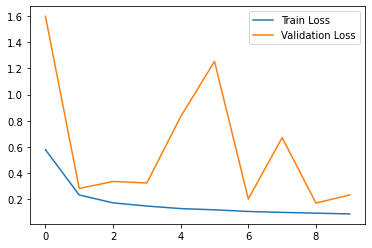

In [26]:
import matplotlib.pyplot as plt

x = [i for i in range(len(valid_loss))]

plt.plot(x, train_loss, label="Train Loss")
plt.plot(x, valid_loss, label="Validation Loss")
plt.legend()
plt.show()

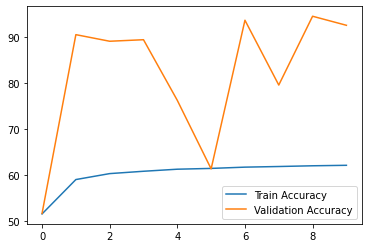

In [29]:
modified_valid_acc = list(map(lambda x: x*100, valid_acc))

plt.plot(x, train_acc, label="Train Accuracy")
plt.plot(x, modified_valid_acc, label="Validation Accuracy")
plt.legend()
plt.show()